In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['TSLA','FB','AMZN','GOOG','TWTR']**

In [7]:
import yfinance as yf
stock_symbol = 'TSLA'
data = yf.download(tickers=stock_symbol,period='4y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
1002,2022-04-21,1074.729980,1092.219971,996.419983,1008.780029,1008.780029,35138800
1003,2022-04-22,1014.909973,1034.849976,994.000000,1005.049988,1005.049988,23181600
1004,2022-04-25,978.969971,1008.619995,975.299988,998.020020,998.020020,22780400
1005,2022-04-26,995.429993,1000.000000,875.000000,876.419983,876.419983,45377900
1006,2022-04-27,898.580017,918.000000,877.359985,881.510010,881.510010,25585300


#### Visualizing the Real Stock Trend

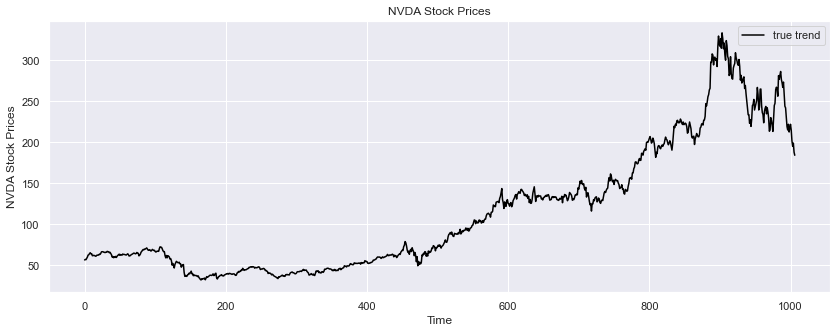

In [6]:
plt.figure(figsize=(14,5))
plt.plot(data['Close'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [62]:
test_size = 250
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((1007, 7), (757, 7), (250, 7))

#### Preparing the training data

In [63]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,57.375000,57.575001,56.154999,56.582500,40084800
1,56.747501,57.250000,56.029999,56.224998,32784400
2,56.142502,56.812500,55.549999,56.785000,25378800
3,56.750000,57.200001,56.312500,56.577499,26824800
4,56.900002,58.512501,56.442501,58.247501,44314400


In [64]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.19977504, 0.19344763, 0.19633441, 0.19145079, 0.12552141])

In [65]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,3])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape

((507, 250, 5), (507,))

#### Preparaing testing data

In [66]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

((500, 5),
           Open       High        Low      Close    Volume
 507  70.220001  72.959999  70.220001  72.822502  31755600
 508  73.867500  75.067497  72.822502  73.434998  36889600
 509  74.232498  75.500000  73.852501  74.447502  32346400
 510  75.845001  76.852501  75.330002  76.217499  37373200
 511  76.937500  78.187500  76.597504  78.125000  33921600)

In [67]:
df = scaler.transform(df)
df[0]

array([0.29942014, 0.31211554, 0.30661572, 0.31675703, 0.09101259])

In [68]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,3])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((250, 250, 5), (250,))

#### Defining the Scaling Label

In [69]:
# below is the scaling label, which will help inverse the transformation back to it's original values 
data_close = data.Close
data_close = data_close.values.reshape(-1, 1)
scaler_close = MinMaxScaler()
data_close_scaled = scaler_close.fit_transform(data_close)

In [70]:
y_test = y_test.reshape(-1,1)
y_test = scaler_close.inverse_transform(y_test)

#### GRU - Gated Recurrent Unit

In [71]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [72]:
x_train.shape[1],x_train.shape[2]

(250, 5)

In [73]:
model = Sequential()

# Input layer
model.add(GRU(units=40,activation='relu',return_sequences=False, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dropout(0.5))

# output layer
model.add(Dense(units=1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 40)                5640      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
Total params: 5,681
Trainable params: 5,681
Non-trainable params: 0
_________________________________________________________________


In [74]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

In [75]:
def forecast():
    model.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = model.predict(x_test)
    y_pred = y_pred.reshape(-1,1)
    y_pred = scaler_close.inverse_transform(y_pred)
    return y_pred

In [76]:
result_forecast = forecast()

Epoch 1/300
16/16 [==============================] - 2s 56ms/step - loss: 0.1801 - accuracy: 0.0000e+00
Epoch 2/300
16/16 [==============================] - 1s 57ms/step - loss: 0.0519 - accuracy: 0.0000e+00
Epoch 3/300
16/16 [==============================] - 1s 57ms/step - loss: 0.0394 - accuracy: 0.0020
Epoch 4/300
16/16 [==============================] - 1s 56ms/step - loss: 0.0260 - accuracy: 0.0020
Epoch 5/300
16/16 [==============================] - 1s 57ms/step - loss: 0.0248 - accuracy: 0.0020
Epoch 6/300
16/16 [==============================] - 1s 57ms/step - loss: 0.0174 - accuracy: 0.0020
Epoch 7/300
16/16 [==============================] - 1s 57ms/step - loss: 0.0208 - accuracy: 0.0020
Epoch 8/300
16/16 [==============================] - 1s 60ms/step - loss: 0.0177 - accuracy: 0.0000e+00
Epoch 9/300
16/16 [==============================] - 1s 57ms/step - loss: 0.0180 - accuracy: 0.0020
Epoch 10/300
16/16 [==============================] - 1s 59ms/step - loss: 0.0186 - accu

#### Calculating the Accuracy using MAPE and RMSE

In [77]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100

mape_accuracy = calculate_accuracy(y_test, result_forecast)
mape_accuracy

91.35375880932493

#### Visualization

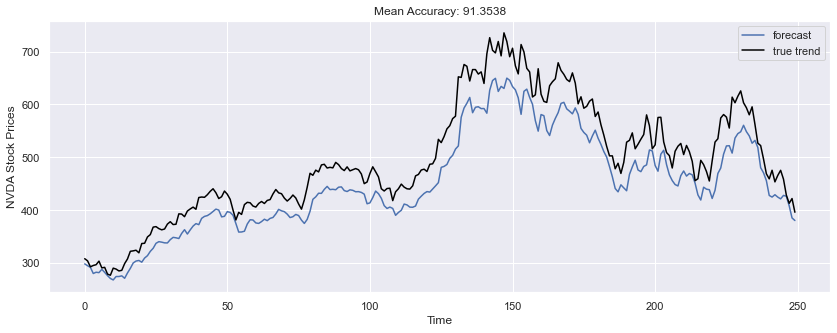

In [78]:
plt.figure(figsize=(14,5))
plt.plot(result_forecast,label='forecast')
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mape_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [5]:
import seaborn as sns
sns.set()

In [80]:
count = int(np.ceil(len(result_forecast) * 0.1))
signals = pd.DataFrame(index=range(test_size))
signals['signal'] = 0.0
signals['trend'] = result_forecast
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,297.643158,NaN,NaN
1,0.0,294.243805,NaN,NaN
2,0.0,291.119507,NaN,NaN
3,0.0,279.457825,NaN,NaN
4,0.0,281.854980,NaN,NaN
...,...,...,...,...
245,0.0,427.419678,560.296936,420.871307
246,0.0,425.829559,560.296936,420.871307
247,1.0,407.724854,560.296936,420.871307
248,1.0,384.703430,560.296936,407.724854


In [81]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [82]:
states_buy, states_sell, total_gains, invest = buy_stock(result_forecast, signals['signal'])

day 25: cannot sell anything, inventory 0
day 26: cannot sell anything, inventory 0
day 30: cannot sell anything, inventory 0
day 31: cannot sell anything, inventory 0
day 34: cannot sell anything, inventory 0
day 35: cannot sell anything, inventory 0
day 38: cannot sell anything, inventory 0
day 39: cannot sell anything, inventory 0
day 41: cannot sell anything, inventory 0
day 42: cannot sell anything, inventory 0
day 43: cannot sell anything, inventory 0
day 44: cannot sell anything, inventory 0
day 45: cannot sell anything, inventory 0
day 46: cannot sell anything, inventory 0
day 80: cannot sell anything, inventory 0
day 81: cannot sell anything, inventory 0
day 82: cannot sell anything, inventory 0
day 84: cannot sell anything, inventory 0
day 85: cannot sell anything, inventory 0
day 105: buy 1 units at price 408.028290, total balance 9591.971680
day 106: buy 1 units at price 402.739227, total balance 9189.232422
day 109: buy 1 units at price 389.711853, total balance 8799.52050

In [ ]:
close =  result_forecast
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()